In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime

'''
This kernel implements the O(n²) F1-Score expectation maximization algorithm presented in
"Ye, N., Chai, K., Lee, W., and Chieu, H.  Optimizing F-measures: A Tale of Two Approaches. In ICML, 2012."

It solves argmax_(0 <= k <= n,[[None]]) E[F1(P,k,[[None]])]
with [[None]] being the indicator for predicting label "None"
given posteriors P = [p_1, p_2, ... , p_n], where p_1 > p_2 > ... > p_n
under label independence assumption by means of dynamic programming in O(n²).
'''


class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)


def print_best_prediction(P, pNone=None):
    print("Maximize F1-Expectation")
    print("=" * 23)
    P = np.sort(P)[::-1]
    n = P.shape[0]
    L = ['L{}'.format(i + 1) for i in range(n)]

    if pNone is None:
        print("Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)")
        pNone = (1.0 - P).prod()

    PL = ['p({}|x)={}'.format(l, p) for l, p in zip(L, P)]
    print("Posteriors: {} (n={})".format(PL, n))
    print("p(None|x)={}".format(pNone))

    opt = F1Optimizer.maximize_expectation(P, pNone)
    best_prediction = ['None'] if opt[1] else []
    best_prediction += (L[:opt[0]])
    f1_max = opt[2]

    print("Prediction {} yields best E[F1] of {}\n".format(best_prediction, f1_max))


def save_plot(P, filename='expected_f1.png'):
    E_F1 = pd.DataFrame(F1Optimizer.get_expectations(P).T, columns=["/w None", "/wo None"])
    best_k, _, max_f1 = F1Optimizer.maximize_expectation(P)

    plt.style.use('ggplot')
    plt.figure()
    E_F1.plot()
    plt.title('Expected F1-Score for \n {}'.format("P = [{}]".format(",".join(map(str, P)))), fontsize=12)
    plt.xlabel('k')
    plt.xticks(np.arange(0, len(P) + 1, 1.0))
    plt.ylabel('E[F1(P,k)]')
    plt.plot([best_k], [max_f1], 'o', color='#000000', markersize=4)
    plt.annotate('max E[F1(P,k)] = E[F1(P,{})] = {:.5f}'.format(best_k, max_f1), xy=(best_k, max_f1),
                 xytext=(best_k, max_f1 * 0.8), arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7),
                 horizontalalignment='center', verticalalignment='top')
    plt.gcf().savefig(filename)

In [30]:
stats_fartuk = pd.read_csv('my_test.csv')
stats_fartuk.head()

,order_id,product_id,pred
0,65432,17330,0.024614
1,65432,27407,0.019706
2,65432,35419,0.021963
3,65432,196,0.033456
4,65432,44635,0.019102


In [22]:
targetcols = pd.read_csv('../input/test_seeds_categorical_xgb.csv', nrows=1, index_col=0).columns.tolist()
targetcols = filter(lambda x: 'reorderedlgb' in x or 'reorderedxgb' in x, targetcols)
targetcols

['reorderedlgb_560_422',
 'reorderedlgb_626_518',
 'reorderedlgb_657_645',
 'reorderedlgb_593_275',
 'reorderedlgb_766_122']

In [16]:
# targetcols2 = pd.read_csv('../input/test_seeds_categorical_xgb.csv', nrows=1, index_col=0).columns.tolist()
# targetcols2 = filter(lambda x: 'reorderedlgb' in x or 'reorderedxgb' in x, targetcols2)
# targetcols2

['reorderedxgb_647_306', 'reorderedxgb_479_55']

In [23]:
stats = pd.read_csv('../input/test_seeds_categorical_xgb.csv', usecols = targetcols + ['order_id', 'product_id'])
# stats2 = pd.read_csv('../input/test_seeds_categorical_xgb.csv', usecols = targetcols2 + ['order_id', 'product_id'])
# stats = pd.merge(stats, stats2, on=['order_id', 'product_id'])
stats.head()

,order_id,product_id,reorderedlgb_560_422,reorderedlgb_626_518,reorderedlgb_657_645,reorderedlgb_593_275,reorderedlgb_766_122
0,2161313,196,0.542746,0.621647,0.560589,0.544509,0.528855
1,2161313,12427,0.362269,0.344512,0.347971,0.357620,0.360427
2,2161313,1747,0.138978,0.135236,0.135864,0.162042,0.148560
3,2161313,10441,0.355103,0.360356,0.372366,0.368704,0.332092
4,2161313,11266,0.246534,0.263470,0.268418,0.267154,0.268809


In [18]:
targetcols += targetcols2
targetcols

['reorderedlgb_532_447',
 'reorderedlgb_572_335',
 'reorderedlgb_199_619',
 'reorderedlgb_78_636',
 'reorderedlgb_502_441',
 'reorderedxgb_647_306',
 'reorderedxgb_479_55']

In [24]:
stats.loc[:, 'reordered'] = stats.loc[:,targetcols].mean(axis=1)
stats.head()

,order_id,product_id,reorderedlgb_560_422,reorderedlgb_626_518,reorderedlgb_657_645,reorderedlgb_593_275,reorderedlgb_766_122,reordered
0,2161313,196,0.542746,0.621647,0.560589,0.544509,0.528855,0.559669
1,2161313,12427,0.362269,0.344512,0.347971,0.357620,0.360427,0.354560
2,2161313,1747,0.138978,0.135236,0.135864,0.162042,0.148560,0.144136
3,2161313,10441,0.355103,0.360356,0.372366,0.368704,0.332092,0.357724
4,2161313,11266,0.246534,0.263470,0.268418,0.267154,0.268809,0.262877


In [25]:
stats.drop(targetcols, axis=1, inplace=True)
stats.head()

,order_id,product_id,reordered
0,2161313,196,0.559669
1,2161313,12427,0.354560
2,2161313,1747,0.144136
3,2161313,10441,0.357724
4,2161313,11266,0.262877


In [19]:
# stats_artiom = pd.read_csv('../input/test_probs_6f.csv')
# stats_artiom['order_id'] = stats.order_id
# stats_artiom['product_id'] = stats.product_id
# stats_artiom.head()

In [21]:
t1 = pd.read_csv('my_test_lstm.csv')

In [19]:
t1.max()

order_id      3.421054e+06
product_id    4.968800e+04
pred          9.424919e-01
dtype: float64

In [2]:
t1 = pd.read_csv('my_test.csv')
t2 = pd.read_csv('my_test_1.csv')
t3 = pd.read_csv('my_test_1_.csv')
t4 = pd.read_csv('my_test_2.csv')
t5 = pd.read_csv('test.csv')
del t5['Unnamed: 0']
del t5['user_id']

In [3]:
t = pd.read_csv('m.csv')

In [4]:
t1['pred'] = t['pred']

In [3]:
t1 = pd.merge(t1, t5, on=['order_id', 'product_id'], how='left')
t5['reordered'] = t1['reordered']
t5['order_id'] = t1['order_id']
t5['product_id'] = t1['product_id']
del t1['reordered']

In [14]:
import pickle
with open('prediction_lgbm.pkl', 'rb') as f:
    t6 = pickle.load(f)

In [15]:
t1 = pd.merge(t1, t6, on=['order_id', 'product_id'], how='left')
t6['prediction'] = t1['prediction']
t6['order_id'] = t1['order_id']
t6['product_id'] = t1['product_id']
del t1['prediction']

In [16]:
import pickle
with open('prediction_arboretum.pkl', 'rb') as f:
    t7 = pickle.load(f)

In [17]:
t1 = pd.merge(t1, t7, on=['order_id', 'product_id'], how='left')
t7['prediction'] = t1['prediction']
t7['order_id'] = t1['order_id']
t7['product_id'] = t1['product_id']
del t1['prediction']

In [24]:
#test_pred1 = (t1.pred + t2.pred + t3.pred + t4.pred) / 4 * 0.4 + t5.reordered * 0.6
test_pred = (t6.prediction * 0.37 + t7.prediction * 0.63) * 1.0 + t1.pred * 0.0
#test_pred = t1.pred

In [19]:
stats = t1.copy()

In [25]:
stats['reordered'] = test_pred

In [8]:
stats = pd.merge(stats, stats_fartuk, on=['order_id', 'product_id'])
# stats = pd.merge(stats, stats_artiom, on=['order_id', 'product_id'])
stats.head()

,order_id,product_id,reordered,pred
0,2161313,196,0.559669,0.530024
1,2161313,12427,0.354560,0.437116
2,2161313,1747,0.144136,0.161370
3,2161313,10441,0.357724,0.376709
4,2161313,11266,0.262877,0.280475


In [9]:
import scipy.stats as st
print st.spearmanr(stats.reordered, stats.pred)[0], 'spearman'
print st.pearsonr(stats.reordered, stats.pred)[0], 'pearson'

0.981154913746 spearman
0.978411579547 pearson


In [10]:
stats.rename(columns={'reordered': 'reordered_my', 
                      'pred': 'reordered_artur', },inplace=True)
#                       'preds':'reordered_artiom'}, inplace=True)
stats.head()

,order_id,product_id,reordered_my,reordered_artur
0,2161313,196,0.559669,0.530024
1,2161313,12427,0.354560,0.437116
2,2161313,1747,0.144136,0.161370
3,2161313,10441,0.357724,0.376709
4,2161313,11266,0.262877,0.280475


In [12]:
stats['reordered'] = 0.6 * stats['reordered_my'] + 0.4 * stats['reordered_artur']# + 0.375 * stats['reordered_artiom'] + 
stats.head()

,order_id,product_id,reordered_my,reordered_artur,reordered
0,2161313,196,0.559669,0.530024,0.547811
1,2161313,12427,0.354560,0.437116,0.387583
2,2161313,1747,0.144136,0.161370,0.151030
3,2161313,10441,0.357724,0.376709,0.365318
4,2161313,11266,0.262877,0.280475,0.269916


In [20]:
# stats.loc[:, ]to_csv('../input/tofred.csv', index=False)

In [26]:
probs = stats.groupby('order_id')['reordered'].agg(lambda x: ' '.join(map(str, x))).reset_index()
probs.columns = ['order_id', 'probs']

prods = stats.groupby('order_id')['product_id'].agg(lambda x: ' '.join(map(str, x))).reset_index()
prods.columns = ['order_id', 'prods']

df = pd.merge(probs, prods, on='order_id')
df['eq_len'] = df.apply(lambda x: len(x['prods'].split()) == len(x['probs'].split()), axis=1)
print(df.shape)

(75000, 4)


In [40]:
df.head()

,order_id,probs,prods,eq_len
0,17,0.185982703994 0.376727711199 0.201091955633 0...,21709 13107 38777 48896 1283 13535 47766 39928...,True
1,34,0.0777892198 0.0469420304575 0.0785897791997 0...,46979 9337 9839 44910 44663 48523 2596 21463 4...,True
2,137,0.424291149008 0.48703073405 0.333961220312 0....,38689 24852 41787 43352 23794 48845 311 35694 ...,True
3,182,0.0766943192724 0.0466264915542 0.031981095359...,33198 27344 18011 49235 23645 47209 13629 9337...,True
4,257,0.0779833655554 0.630536851307 0.0574715239575...,38558 24852 15438 49235 4605 30233 12456 27104...,True


In [12]:
df.shape

(75000, 4)

In [27]:
from multiprocessing import Pool, Queue, cpu_count

thread_safe_queue = Queue()
optimizer = F1Optimizer()

def func(idx):
    row = df.loc[idx, :]
    prb = map(float, row['probs'].split())
    prd = map(int, row['prods'].split())
    items = sorted(list(zip(prb, prd)), key=lambda x: x[0], reverse=True)
    best_k, pnone, maxf1 = optimizer.maximize_expectation([x[0] for x in items])
    order_id = row['order_id']
    solution = ['None'] if pnone == True else []
    solution += [x[1] for x in items[:best_k]]
    thread_safe_queue.put({'order_id': order_id, 'products': ' '.join(map(str,solution))})
    if thread_safe_queue.qsize() % 5000 == 0:
        print(thread_safe_queue.qsize())
    
pool = Pool(processes=cpu_count()) # cpu_count()
pool.map(func, range(df.shape[0])) # process each row in parallel
print(thread_safe_queue.qsize())
pool.close()

all_dicts = [thread_safe_queue.get() for _ in range(thread_safe_queue.qsize())]
submit = pd.DataFrame(all_dicts)
print(submit.shape)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
75000
(75000, 2)


In [28]:
submit.sort_values('order_id').to_csv('my_1.csv', index=False)

In [13]:
submit.sort_values('order_id').head(150)

,order_id,products
3,17,13107 21463 38777 47766 21709
8,34,16083 39475 47766 43504 2596 21137 47792 39180...
19,137,24852 38689 23794 41787 25890 2326 5134
27,182,9337 5479 39275 13629 47672 32109 11520 41149 ...
37,257,24852 49235 37646 27966 27104 29837 39475 3023...
45,313,45007 12779 46906 21903 30391 28535 13198 25890
47,353,35561 40688 33000 48183 21137
56,386,24852 47766 45066 39180 42265 38281 15872 2147...
63,414,20392 21230 27845 33320 20564 21709 4472 7539 ...
67,418,47766 40268 30489 5262 13702 41950 4605


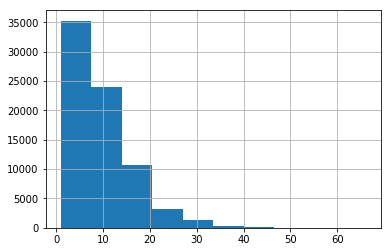

In [32]:
%matplotlib inline
predicted = submit.apply(lambda x: len(x.products.split()), axis=1)
predicted.hist()